In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../../src')
from ecomplexity import ecomplexity
import matplotlib.pyplot as plt

import matplotlib.ticker as ptick
import networkx as nx
import networkx.algorithms.bipartite as bip
plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['font.size'] = 15

# 小数点以下 桁数 6
pd.options.display.float_format = '{:.3f}'.format


In [2]:
import initial_condition
from analysis import weight
from analysis import rank as vr


In [3]:
global data_dir, output_dir
data_dir = '../../data/processed/internal/technology/'
ex_dir = '../../data/processed/external/schmoch/'
output_dir = '../../output/'


In [4]:
# 初期条件
ar = initial_condition.AR
year_style = initial_condition.YEAR_STYLE

year_start = initial_condition.YEAR_START
year_end = initial_condition.YEAR_END
year_range = initial_condition.YEAR_RANGE

classification = initial_condition.CLASSIFICATION
class_weight = initial_condition.CLASS_WEIGHT
applicant_weight = initial_condition.APPLICANT_WEIGHT

extract_population = initial_condition.EXTRACT_POPULATION
top_p_or_num = initial_condition.TOP_P_OR_NUM
# top_p_or_num = ('num', 300)

color_list = initial_condition.COLOR_LIST

In [5]:
df = pd.read_csv(f'{data_dir}{ar}_{year_style}_{top_p_or_num[0]}_{top_p_or_num[1]}.csv', 
                 sep=',')
schmoch_df = pd.read_csv(f'{ex_dir}35.csv', 
                         encoding='utf-8', 
                         sep=',', 
                         usecols=['Field_number', 'Field_en']
                         ).drop_duplicates()
df = pd.merge(df, schmoch_df, left_on=classification, 
              right_on='Field_number', how='left').drop(columns=['Field_number', classification])\
    .rename(columns={'Field_en': classification})
df

,app_year_period,reg_num,right_person_name,ubiquity,tci,ki_1,ki_2,ki_3,ki_4,ki_5,...,ki_12,ki_13,ki_14,ki_15,ki_16,ki_17,ki_18,ki_19,ki_20,schmoch35
0,1981-1990,53234.148,912,300,-1.356,5.800,302.377,6.272,311.493,6.429,...,323.399,6.567,324.015,6.573,324.370,6.577,324.576,6.579,324.694,"Electrical machinery, apparatus, energy"
1,1981-1990,52234.681,676,165,-2.402,5.830,246.742,6.238,285.156,6.394,...,321.623,6.559,323.079,6.568,323.871,6.574,324.306,6.578,324.547,Audio-visual technology
2,1981-1990,23838.704,422,144,-3.024,6.243,230.501,6.302,275.708,6.380,...,320.856,6.552,322.658,6.565,323.637,6.572,324.175,6.576,324.473,Telecommunications
3,1981-1990,4176.887,187,100,-3.299,6.690,217.850,6.339,270.287,6.372,...,320.476,6.550,322.452,6.563,323.524,6.571,324.112,6.576,324.438,Digital communication
4,1981-1990,12226.667,327,157,-3.086,6.057,227.268,6.274,273.558,6.377,...,320.718,6.552,322.587,6.564,323.600,6.572,324.156,6.576,324.463,Basic communication processes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2001-2010,32259.182,992,353,0.213,6.062,351.410,6.580,344.874,6.843,...,334.903,7.060,334.580,7.065,334.427,7.068,334.354,7.069,334.320,Mechanical elements
136,2001-2010,58969.810,685,234,-0.232,5.534,324.329,6.386,336.496,6.759,...,334.498,7.055,334.361,7.063,334.308,7.067,334.289,7.069,334.284,Transport
137,2001-2010,56681.917,685,185,-0.402,4.427,278.482,5.849,314.587,6.520,...,333.896,7.047,334.113,7.060,334.202,7.065,334.243,7.068,334.263,"Furniture, games"
138,2001-2010,17090.667,708,260,0.154,6.196,315.534,6.718,329.397,6.934,...,334.339,7.067,334.329,7.069,334.315,7.070,334.303,7.070,334.296,Other consumer goods


In [6]:
schmoch_df[schmoch_df['Field_en'].str.contains('nano')]

,Field_number,Field_en
307,22,Micro-structural and nano-technology


In [7]:
df[df[f'{ar}_{year_style}_period']=='1981-2010']['reg_num'].sum()

2836473.999062538

In [8]:
df[df[classification].str.contains('nano')]

,app_year_period,reg_num,right_person_name,ubiquity,tci,ki_1,ki_2,ki_3,ki_4,ki_5,...,ki_12,ki_13,ki_14,ki_15,ki_16,ki_17,ki_18,ki_19,ki_20,schmoch35
21,1981-1990,0.500,1,1,2.030,13.000,299.692,7.514,325.713,6.879,...,326.188,6.607,325.701,6.596,325.378,6.590,325.172,6.587,325.045,Micro-structural and nano-technology
56,1981-2010,739.333,145,115,-0.877,9.548,305.425,7.668,338.312,7.361,...,355.181,7.272,355.862,7.272,356.243,7.273,356.456,7.273,356.575,Micro-structural and nano-technology
91,1991-2000,91.750,38,32,-1.070,9.312,275.881,7.049,317.316,6.754,...,336.503,6.710,337.259,6.712,337.688,6.713,337.931,6.714,338.070,Micro-structural and nano-technology
126,2001-2010,647.083,134,110,-0.790,9.709,289.591,7.551,318.726,7.197,...,333.236,7.072,333.730,7.070,333.991,7.070,334.130,7.070,334.203,Micro-structural and nano-technology


In [9]:
df[df['schmoch35'].isin(['Analysis of biological materials',
 'Organic fine chemistry',
 'Biotechnology',
 'Pharmaceuticals',
 'Macromolecular chemistry, polymers',
 'Food chemistry',
 'Basic materials chemistry',
 'Materials, metallurgy',
 'Surface technology, coating',
 'Chemical engineering',
 'Other special machines'])&(df[f'{ar}_{year_style}_period']=='1981-2010')]

,app_year_period,reg_num,right_person_name,ubiquity,tci,ki_1,ki_2,ki_3,ki_4,ki_5,...,ki_12,ki_13,ki_14,ki_15,ki_16,ki_17,ki_18,ki_19,ki_20,schmoch35
45,1981-2010,6877.317,602,370,1.084,8.446,374.670,7.783,367.709,7.518,...,358.089,7.290,357.514,7.283,357.179,7.279,356.985,7.277,356.874,Analysis of biological materials
48,1981-2010,49719.293,661,333,1.605,8.228,369.649,7.959,370.669,7.633,...,358.772,7.299,357.911,7.287,357.408,7.281,357.117,7.278,356.950,Organic fine chemistry
49,1981-2010,18705.417,609,378,1.375,8.683,371.834,7.898,369.121,7.583,...,358.472,7.295,357.736,7.285,357.307,7.280,357.059,7.277,356.916,Biotechnology
50,1981-2010,13663.633,440,292,1.664,8.408,366.312,7.983,370.208,7.645,...,358.838,7.300,357.952,7.288,357.433,7.281,357.131,7.278,356.958,Pharmaceuticals
51,1981-2010,73506.540,855,297,1.311,8.236,380.236,7.700,372.734,7.493,...,358.480,7.291,357.727,7.283,357.296,7.279,357.051,7.277,356.911,"Macromolecular chemistry, polymers"
52,1981-2010,19087.025,590,292,1.448,8.007,370.772,7.734,370.553,7.528,...,358.616,7.294,357.816,7.284,357.351,7.280,357.083,7.277,356.930,Food chemistry
53,1981-2010,49545.462,1110,470,1.192,8.021,384.068,7.681,371.108,7.484,...,358.301,7.290,357.626,7.282,357.240,7.279,357.019,7.277,356.893,Basic materials chemistry
54,1981-2010,96515.604,1104,344,0.737,8.320,385.709,7.547,371.356,7.373,...,357.789,7.280,357.315,7.278,357.055,7.276,356.911,7.275,356.830,"Materials, metallurgy"
55,1981-2010,69831.193,1278,483,0.707,7.621,389.737,7.405,370.287,7.336,...,357.730,7.280,357.284,7.277,357.038,7.276,356.902,7.275,356.825,"Surface technology, coating"
57,1981-2010,48567.232,1396,600,0.870,7.928,400.895,7.505,371.951,7.375,...,357.945,7.282,357.411,7.279,357.112,7.277,356.944,7.276,356.849,Chemical engineering


1981-2010 -0.063


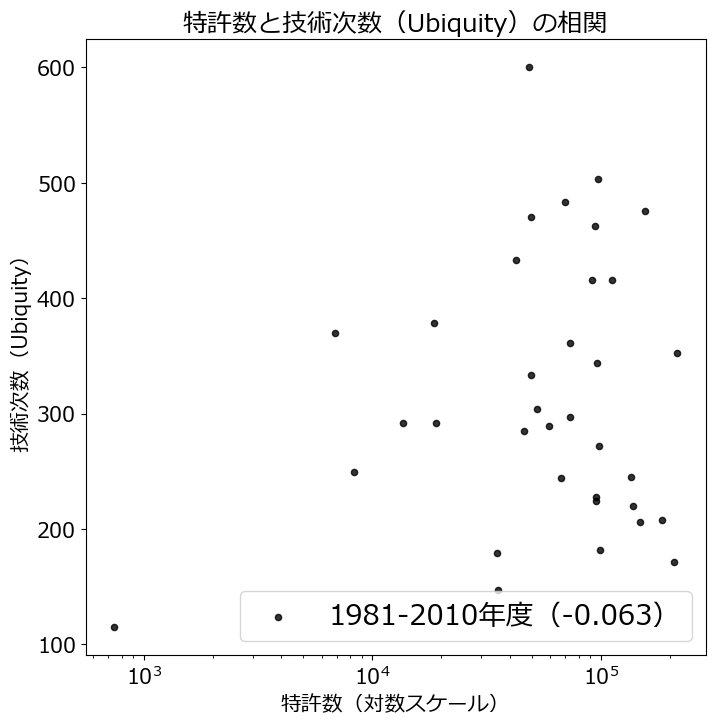

1981-2010 -0.292


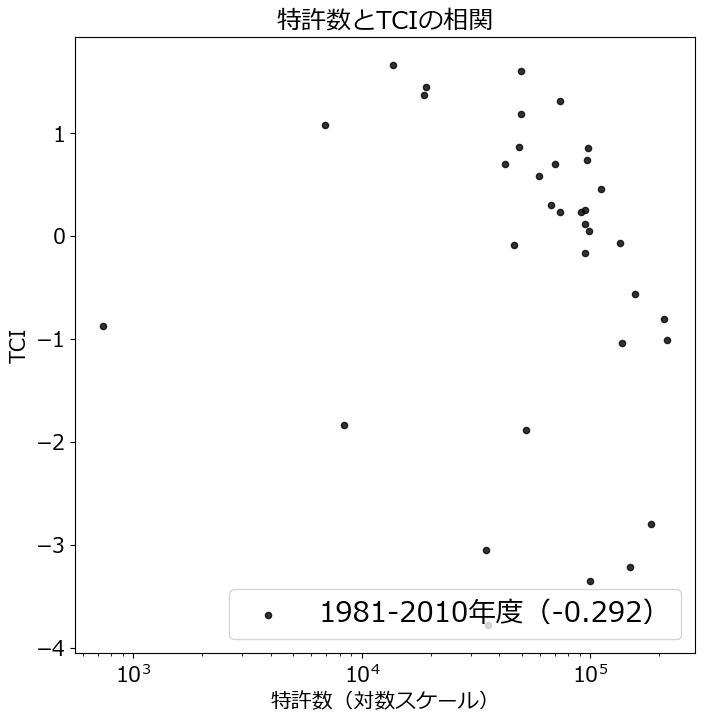

1981-2010 0.59


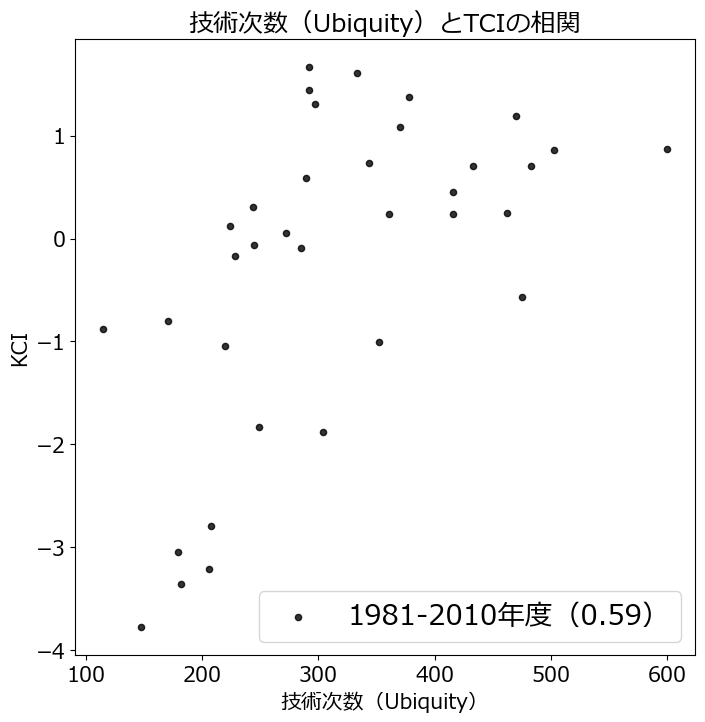

1981-2010 0.055


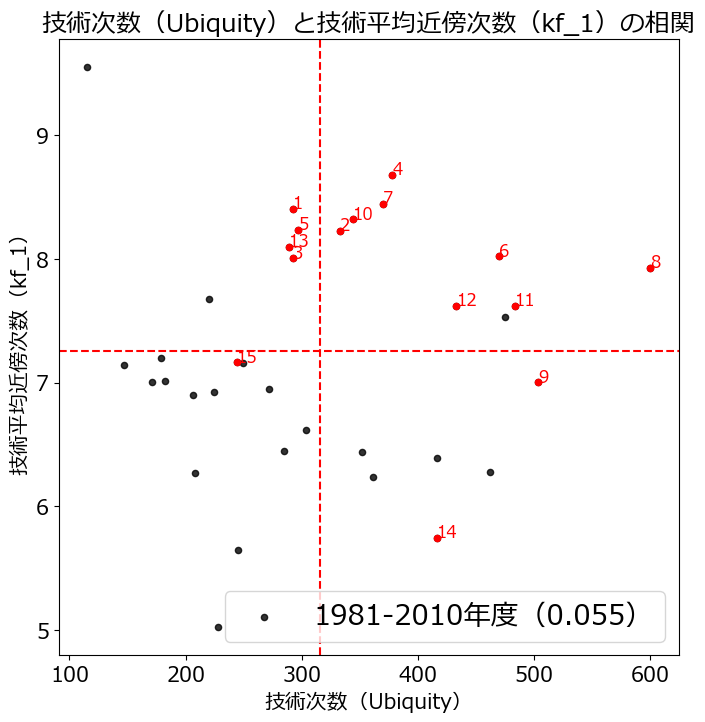

In [10]:
df_dict = {}
combi_dict = {# ind: [x, y, title, xlabel, ylabel, legend_loc]
              1: ['reg_num', 'ubiquity', '特許数と技術次数（Ubiquity）の相関', '特許数（対数スケール）', '技術次数（Ubiquity）', 'lower right'], 
              2: ['reg_num', 'tci', '特許数とTCIの相関', '特許数（対数スケール）', 'TCI', 'lower right'], 
              3: ['ubiquity', 'tci', '技術次数（Ubiquity）とTCIの相関', '技術次数（Ubiquity）', 'KCI', 'lower right'], 
              4: ['ubiquity', 'ki_1', '技術次数（Ubiquity）と技術平均近傍次数（kf_1）の相関', '技術次数（Ubiquity）', '技術平均近傍次数（kf_1）', 'lower right']
              }

for i, combi in combi_dict.items():
    fig, ax = plt.subplots(figsize=(8, 8))
    period = f'{year_start}-{year_end}'
    corr_num = round(df[df[f'{ar}_{year_style}_period']==period][combi[0]].corr(df[df[f'{ar}_{year_style}_period']==period][combi[1]]), 3)
    print(period, corr_num)
    ax.scatter(df[df[f'{ar}_{year_style}_period']==period][combi[0]], 
                df[df[f'{ar}_{year_style}_period']==period][combi[1]], s=20, 
                alpha=0.8, label=f'{period}年度（{corr_num}）', color='black')
    if i == 4:
        ax.axvline(x=df[df[f'{ar}_{year_style}_period']==period][combi[0]].mean(), color='red', linestyle='--')
        ax.axhline(y=df[df[f'{ar}_{year_style}_period']==period][combi[1]].mean(), color='red', linestyle='--')
    ax.set_title(combi[2])
    if combi[0] in ['reg_num']: ax.set_xscale('log')
    if combi[1] in ['reg_num']: ax.set_yscale('log')
    x_min = df[(df[f'{ar}_{year_style}_period']==period)][combi[0]].min()
    x_2smallest = df[(df[f'{ar}_{year_style}_period']==period)][combi[0]].nsmallest(2).iloc[1]
    y_2smallest = df[(df[f'{ar}_{year_style}_period']==period)][combi[1]].nsmallest(2).iloc[1]
    if i == 4: 
        # ax.text(x_min-1,
        #         df[(df[f'{ar}_{year_style}_period']==period)&(df[combi[0]]==x_min)][combi[1]].values[0]-0.5, 
        #         df[(df[f'{ar}_{year_style}_period']==period)&(df[combi[0]]==x_min)]['right_person_name'].values[0], 
        #         fontsize=15, color='red')
        # ax.text(x_min-1,
        #         df[(df[f'{ar}_{year_style}_period']==period)&(df[combi[0]]==x_2smallest)][combi[1]].values[0]-0.5, 
        #         df[(df[f'{ar}_{year_style}_period']==period)&(df[combi[0]]==x_2smallest)]['right_person_name'].values[0], 
        #         fontsize=15, color='red')
        # ax.text(df[(df[f'{ar}_{year_style}_period']==period)&(df[combi[1]]==y_2smallest)][combi[0]].values[0]-1,
        #         y_2smallest-0.5, 
        #         df[(df[f'{ar}_{year_style}_period']==period)&(df[combi[1]]==y_2smallest)]['right_person_name'].values[0], 
        #         fontsize=15, color='red')
        for i, row in df[(df[f'{ar}_{year_style}_period']==period)].sort_values('tci', ascending=False).reset_index(drop=True).iterrows():
            
        #     # if row['right_person_name'] in df[(df[f'{ar}_{year_style}_period']==period)].sort_values('kci', ascending=False).iloc[25:51,:]['right_person_name'].values:
        #     #     # ax.text(row[combi[0]], row[combi[1]]-0.5, i+1, fontsize=12, color='orange')
        #     #     if i+1!=51: ax.scatter(row[combi[0]], row[combi[1]], s=20, color='orange')
        #     # if row['right_person_name'] in df[(df[f'{ar}_{year_style}_period']==period)].sort_values('kci', ascending=False).iloc[51:76,:]['right_person_name'].values:
        #     #     # ax.text(row[combi[0]], row[combi[1]]-0.5, i+1, fontsize=12, color='green')
        #     #     ax.scatter(row[combi[0]], row[combi[1]], s=20, color='green')
        #     if row['right_person_name'] in df[(df[f'{ar}_{year_style}_period']==period)].sort_values('kci', ascending=False).tail(25)['right_person_name'].values:
        #         ax.text(row[combi[0]], row[combi[1]]-0.5, i+1, fontsize=10, color='blue')
        #         ax.scatter(row[combi[0]], row[combi[1]], s=20, color='blue')
            if row['schmoch35'] in df[(df[f'{ar}_{year_style}_period']==period)].sort_values('tci', ascending=False).head(15)['schmoch35'].values:
                ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=12, color='red')
                ax.scatter(row[combi[0]], row[combi[1]], s=20, color='red')
        
    ax.set_ylabel(combi[4])
    ax.set_xlabel(combi[3])
    ax.legend(loc=combi[5], fontsize=20)
    plt.show()
    

C:\Users\rin\AppData\Local\Temp\ipykernel_4208\805485573.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(plot_df.index, fontsize=15)
C:\Users\rin\AppData\Local\Temp\ipykernel_4208\805485573.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x for x in range(0, 80000+1, 20000)], fontsize=20, rotation=90)
C:\Users\rin\AppData\Local\Temp\ipykernel_4208\805485573.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  xax2.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=20, rotation=90)
C:\Users\rin\AppData\Local\Temp\ipykernel_4208\805485573.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(plot_df.index, fontsize=15)
C:\Users\rin\AppData\Local\Temp\ipykernel_4208\805485573.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x for x in rang

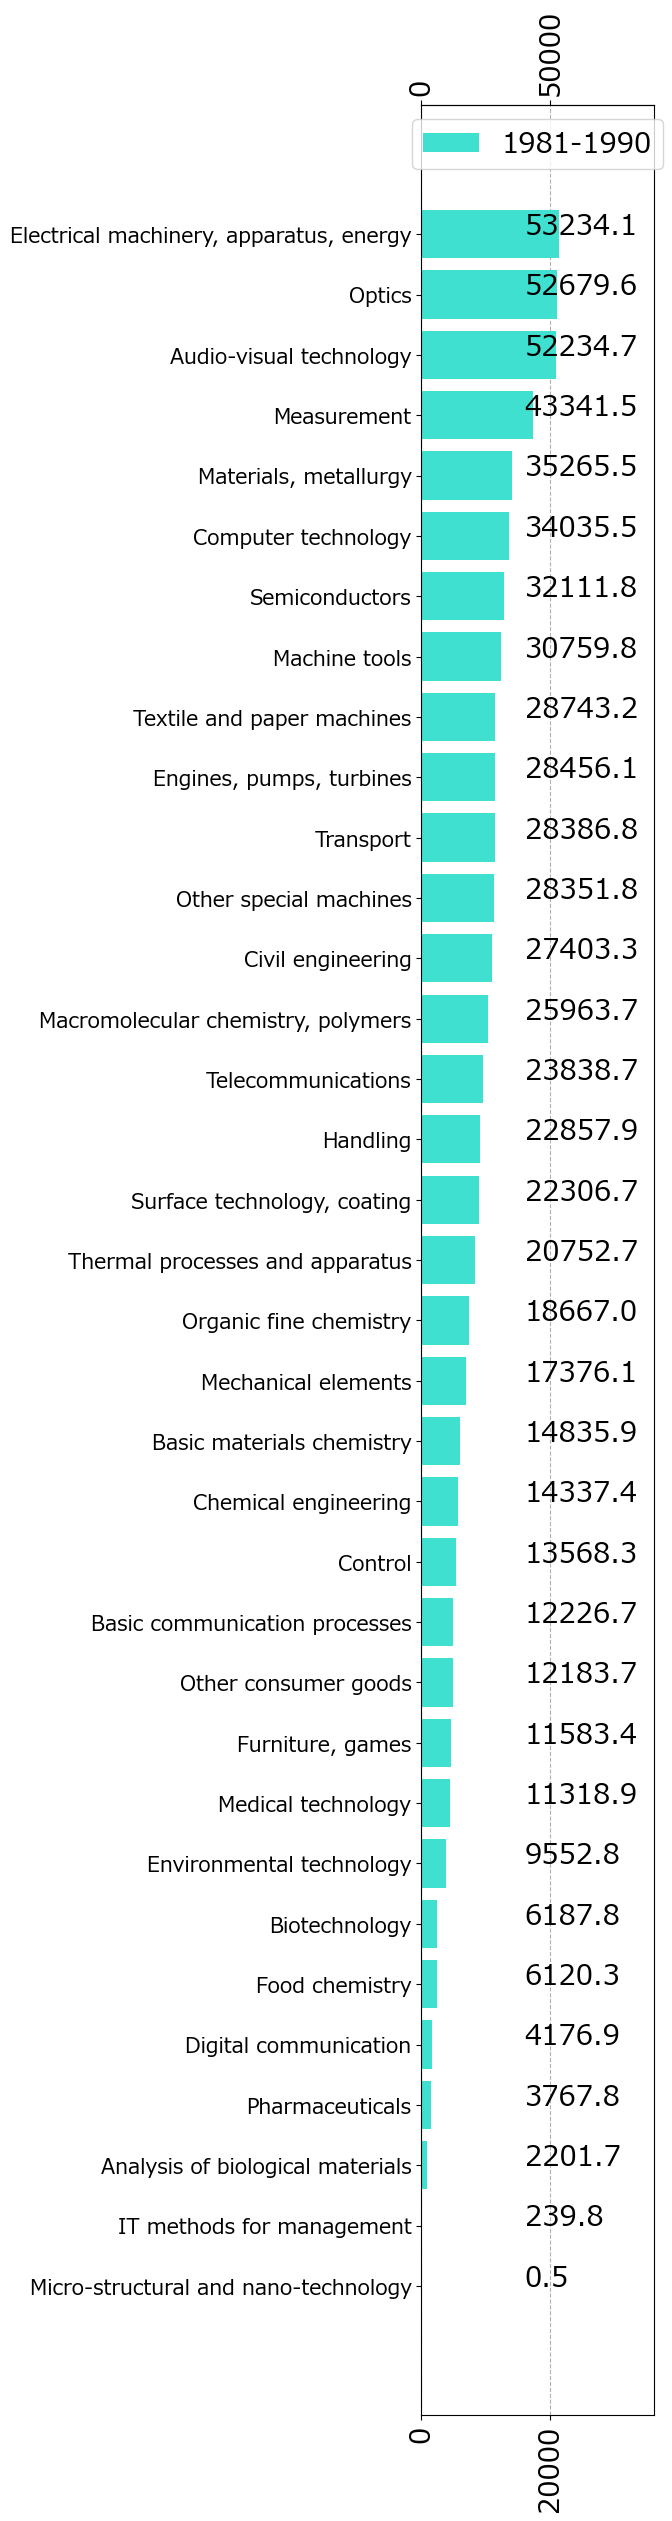

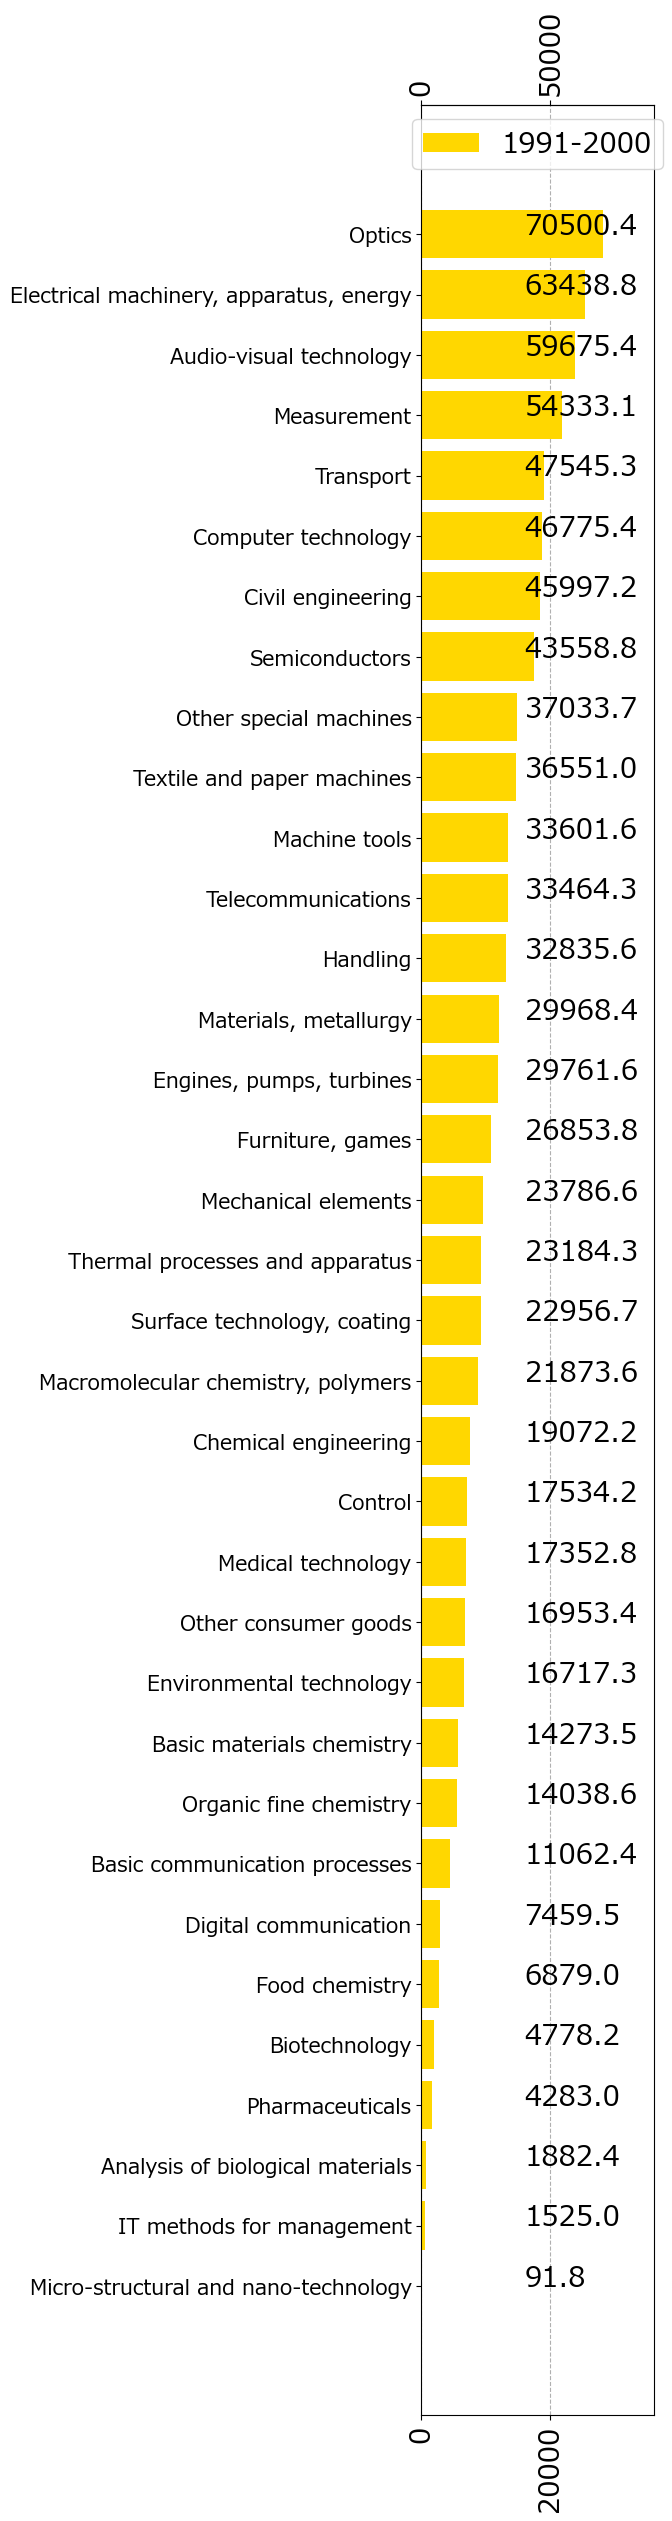

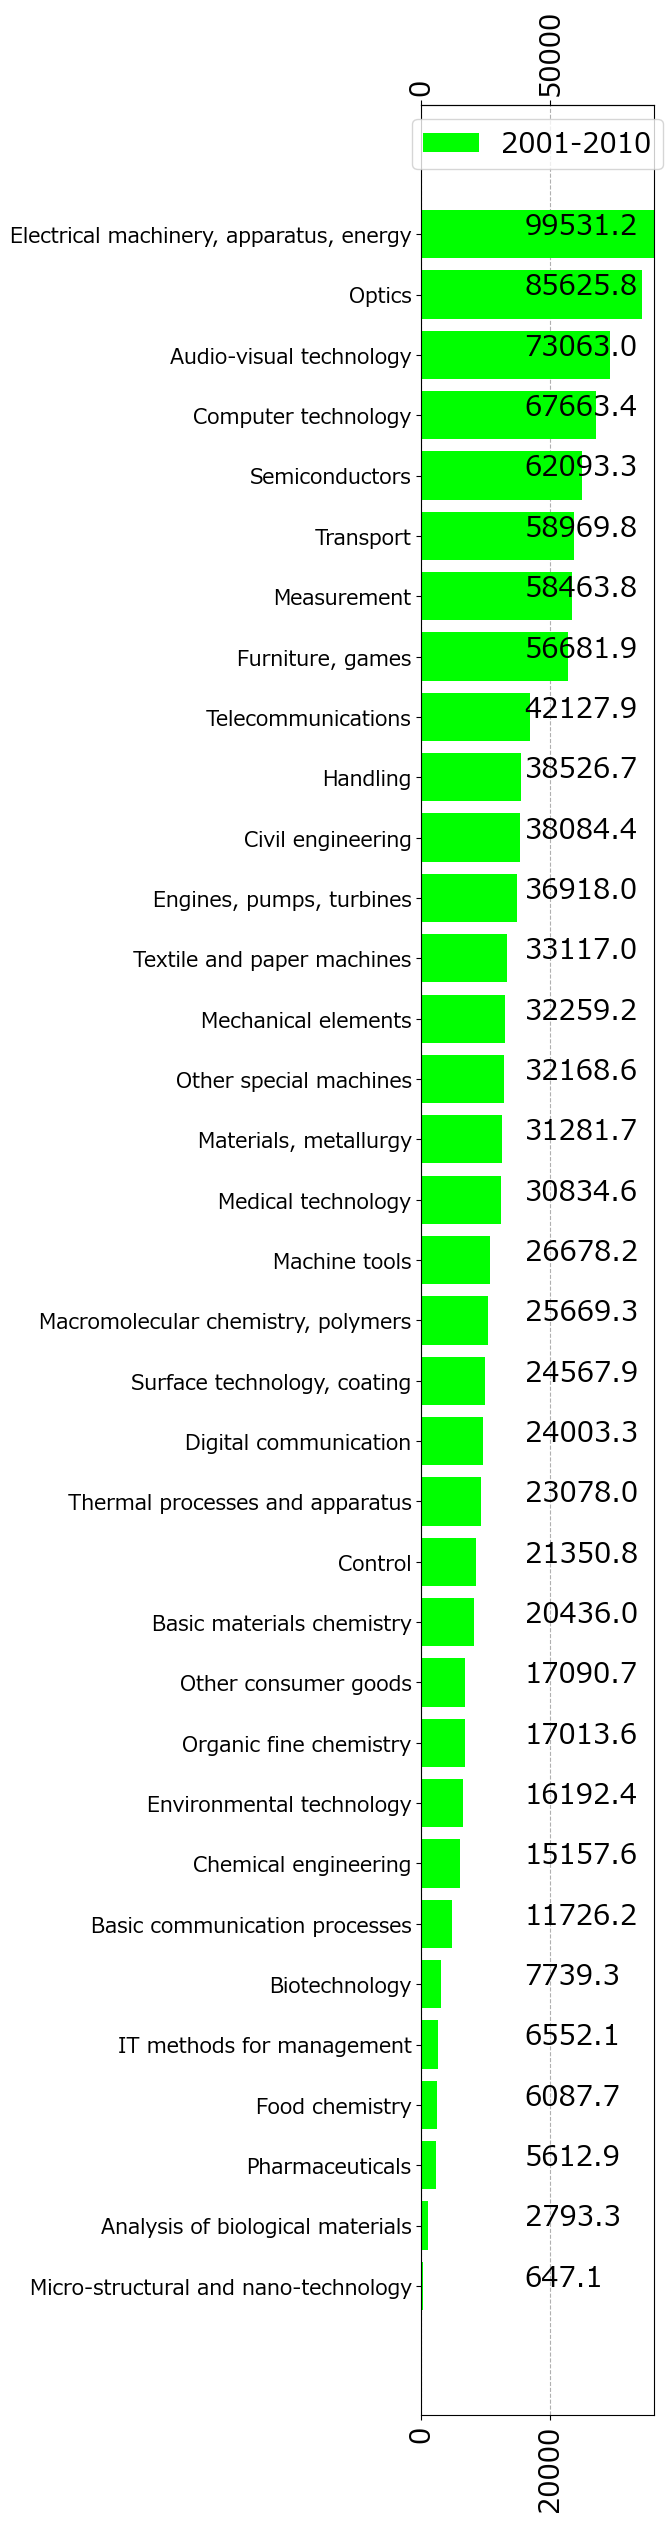

In [11]:
# fig, ax = plt.subplots(figsize=(20, 40), squeeze=False, sharey=False)


color_count = 0
for period in range(year_start, year_end+1, year_range):
     fig, ax = plt.subplots(figsize=(3, 30))
     period = f'{period}-{period+year_range-1}'
     plot_df = df[df[f'{ar}_{year_style}_period'] == period].groupby([classification])[['reg_num']].sum().sort_values('reg_num', ascending=True)
     ax.barh(list(plot_df.index), list(plot_df['reg_num'].values), color=color_list[color_count], label=period)
     ax.set_yticklabels(plot_df.index, fontsize=15)
     ax.set_xticklabels([x for x in range(0, 80000+1, 20000)], fontsize=20, rotation=90)
     ax.set_xlim(0, 90000)
     # ax.set_xticklabels(fontsize=15, rotation=90)
     xax2 = ax.secondary_xaxis('top')
     # xax2.xaxis.set_major_formatter(ptick.FuncFormatter(lambda x, _: f'{int(x):,}'))
     xax2.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=20, rotation=90)
     xax2.set_xlim(ax.get_xlim())
     ax.legend(fontsize=20, loc='upper center')
     ax.set_axisbelow(True)
     ax.grid(which='major', axis='x', linestyle='--')
     c_i = 0
     for c in plot_df.index:
          reg_num = plot_df[plot_df.index==c]['reg_num'].values[0]
          ax.text(x=40000, y=c_i, s=round(reg_num, 1), fontsize=20, color='black')
     #     ax.set_xticklabels(df[df[f'{ar}_{year_style}_period'] == period].groupby([classification])['reg_num'].sum().index, rotation=90, fontsize=15)
          c_i += 1
     color_count += 1
plt.show()

In [12]:
plot_df

,reg_num
schmoch35,
Micro-structural and nano-technology,647.083
Analysis of biological materials,2793.283
Pharmaceuticals,5612.900
Food chemistry,6087.733
IT methods for management,6552.128
Biotechnology,7739.317
Basic communication processes,11726.250
Chemical engineering,15157.638
Environmental technology,16192.391


c:\Users\rin\Desktop\KCIinJapaneseFirms\notebooks\3_analysis\../../src\analysis\rank.py:315: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


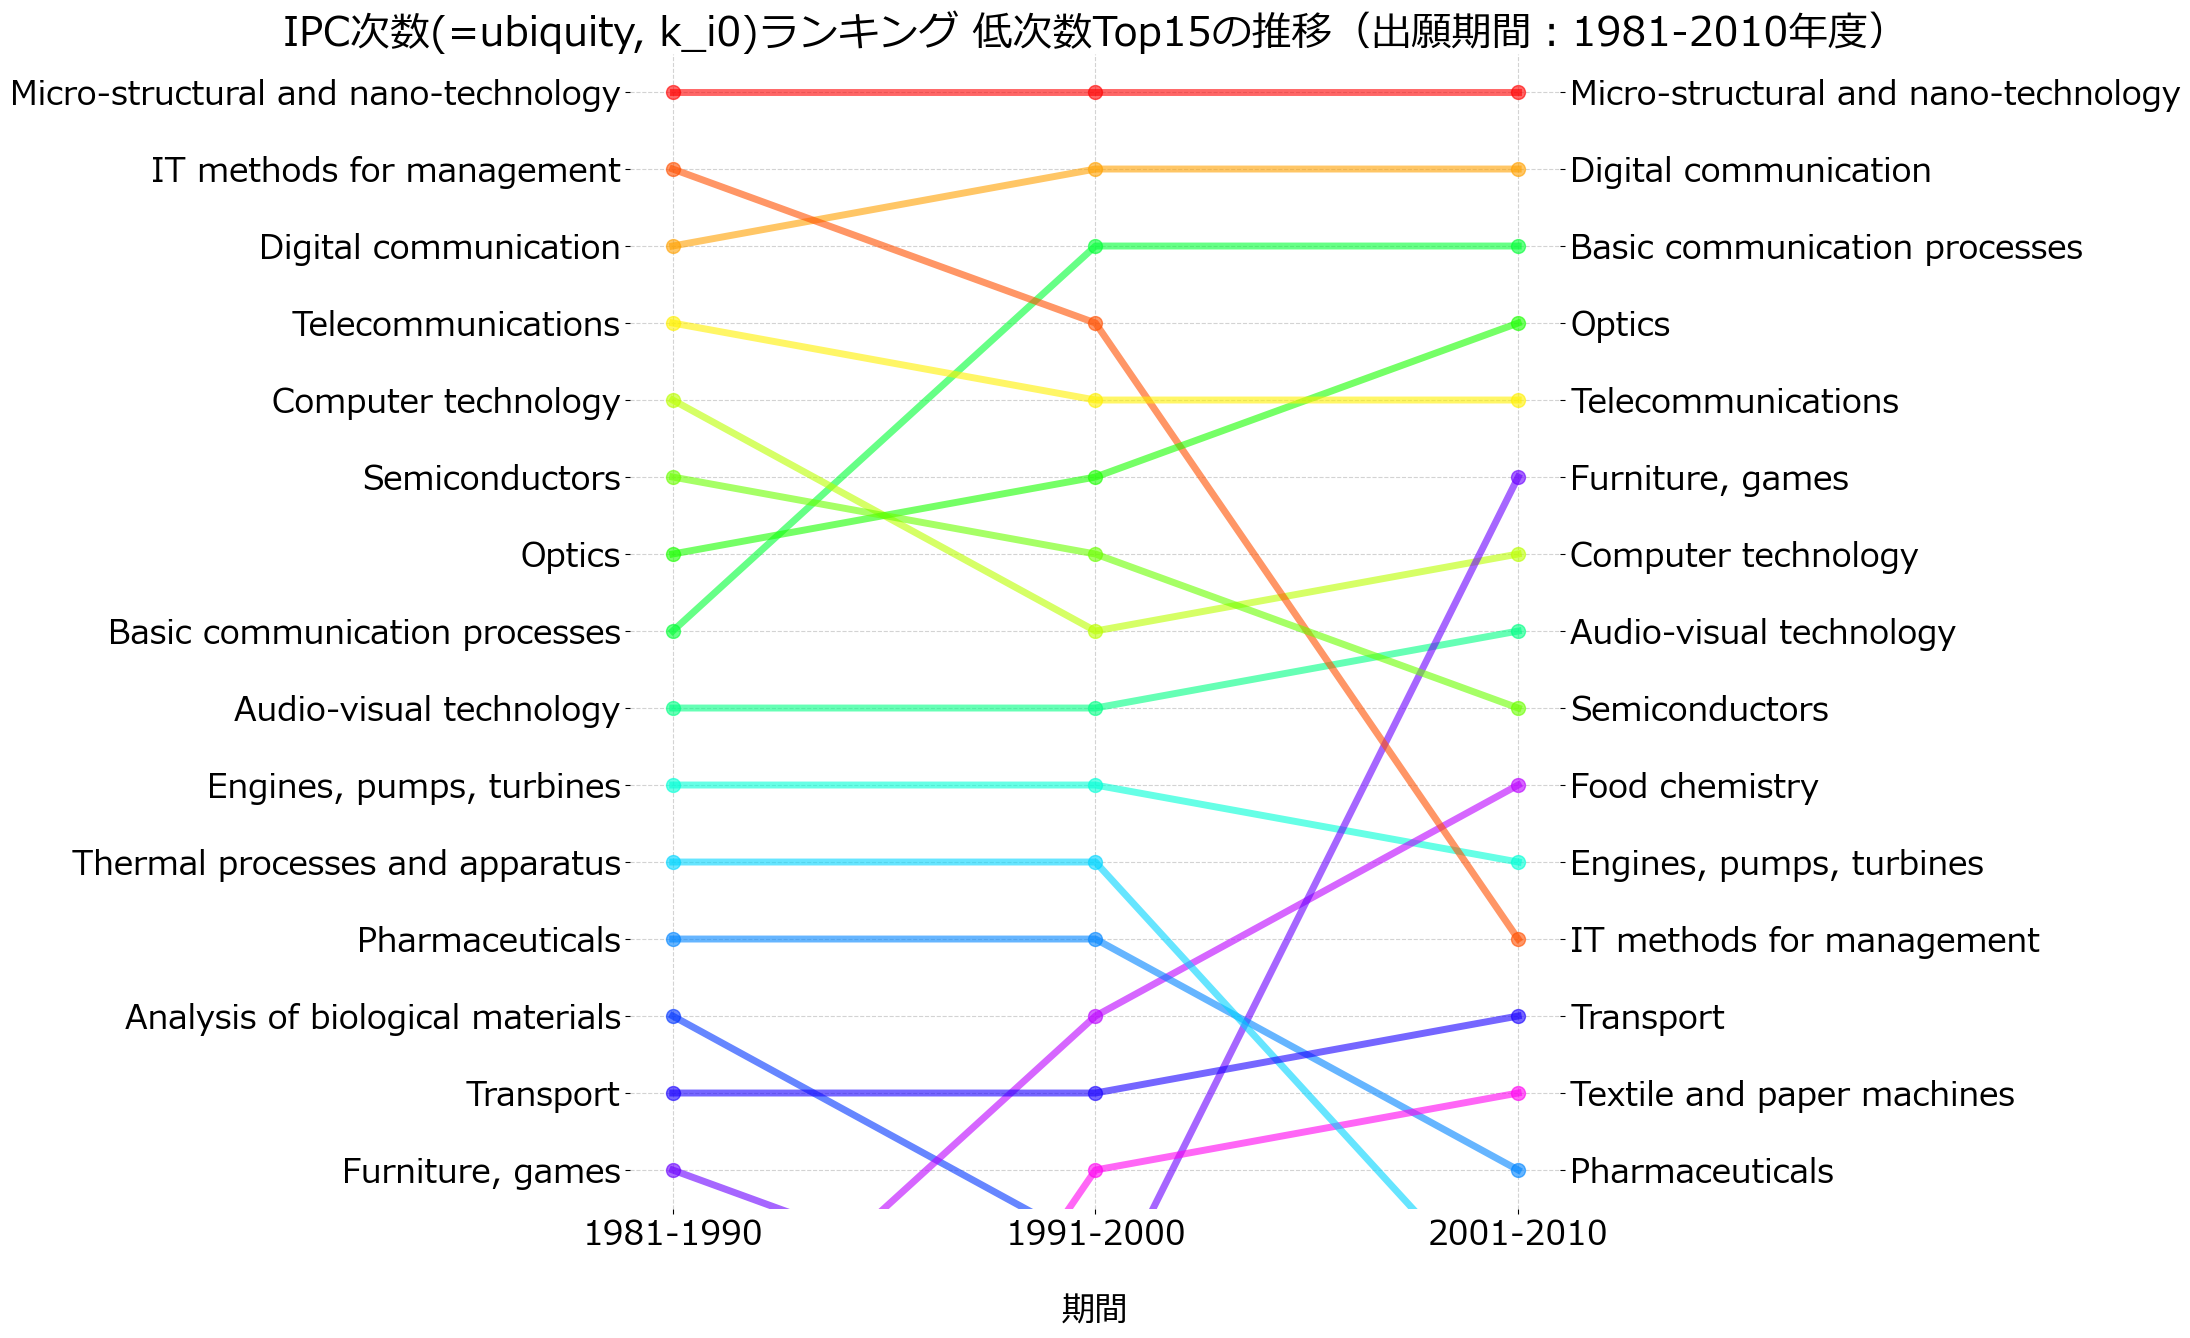

c:\Users\rin\Desktop\KCIinJapaneseFirms\notebooks\3_analysis\../../src\analysis\rank.py:315: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


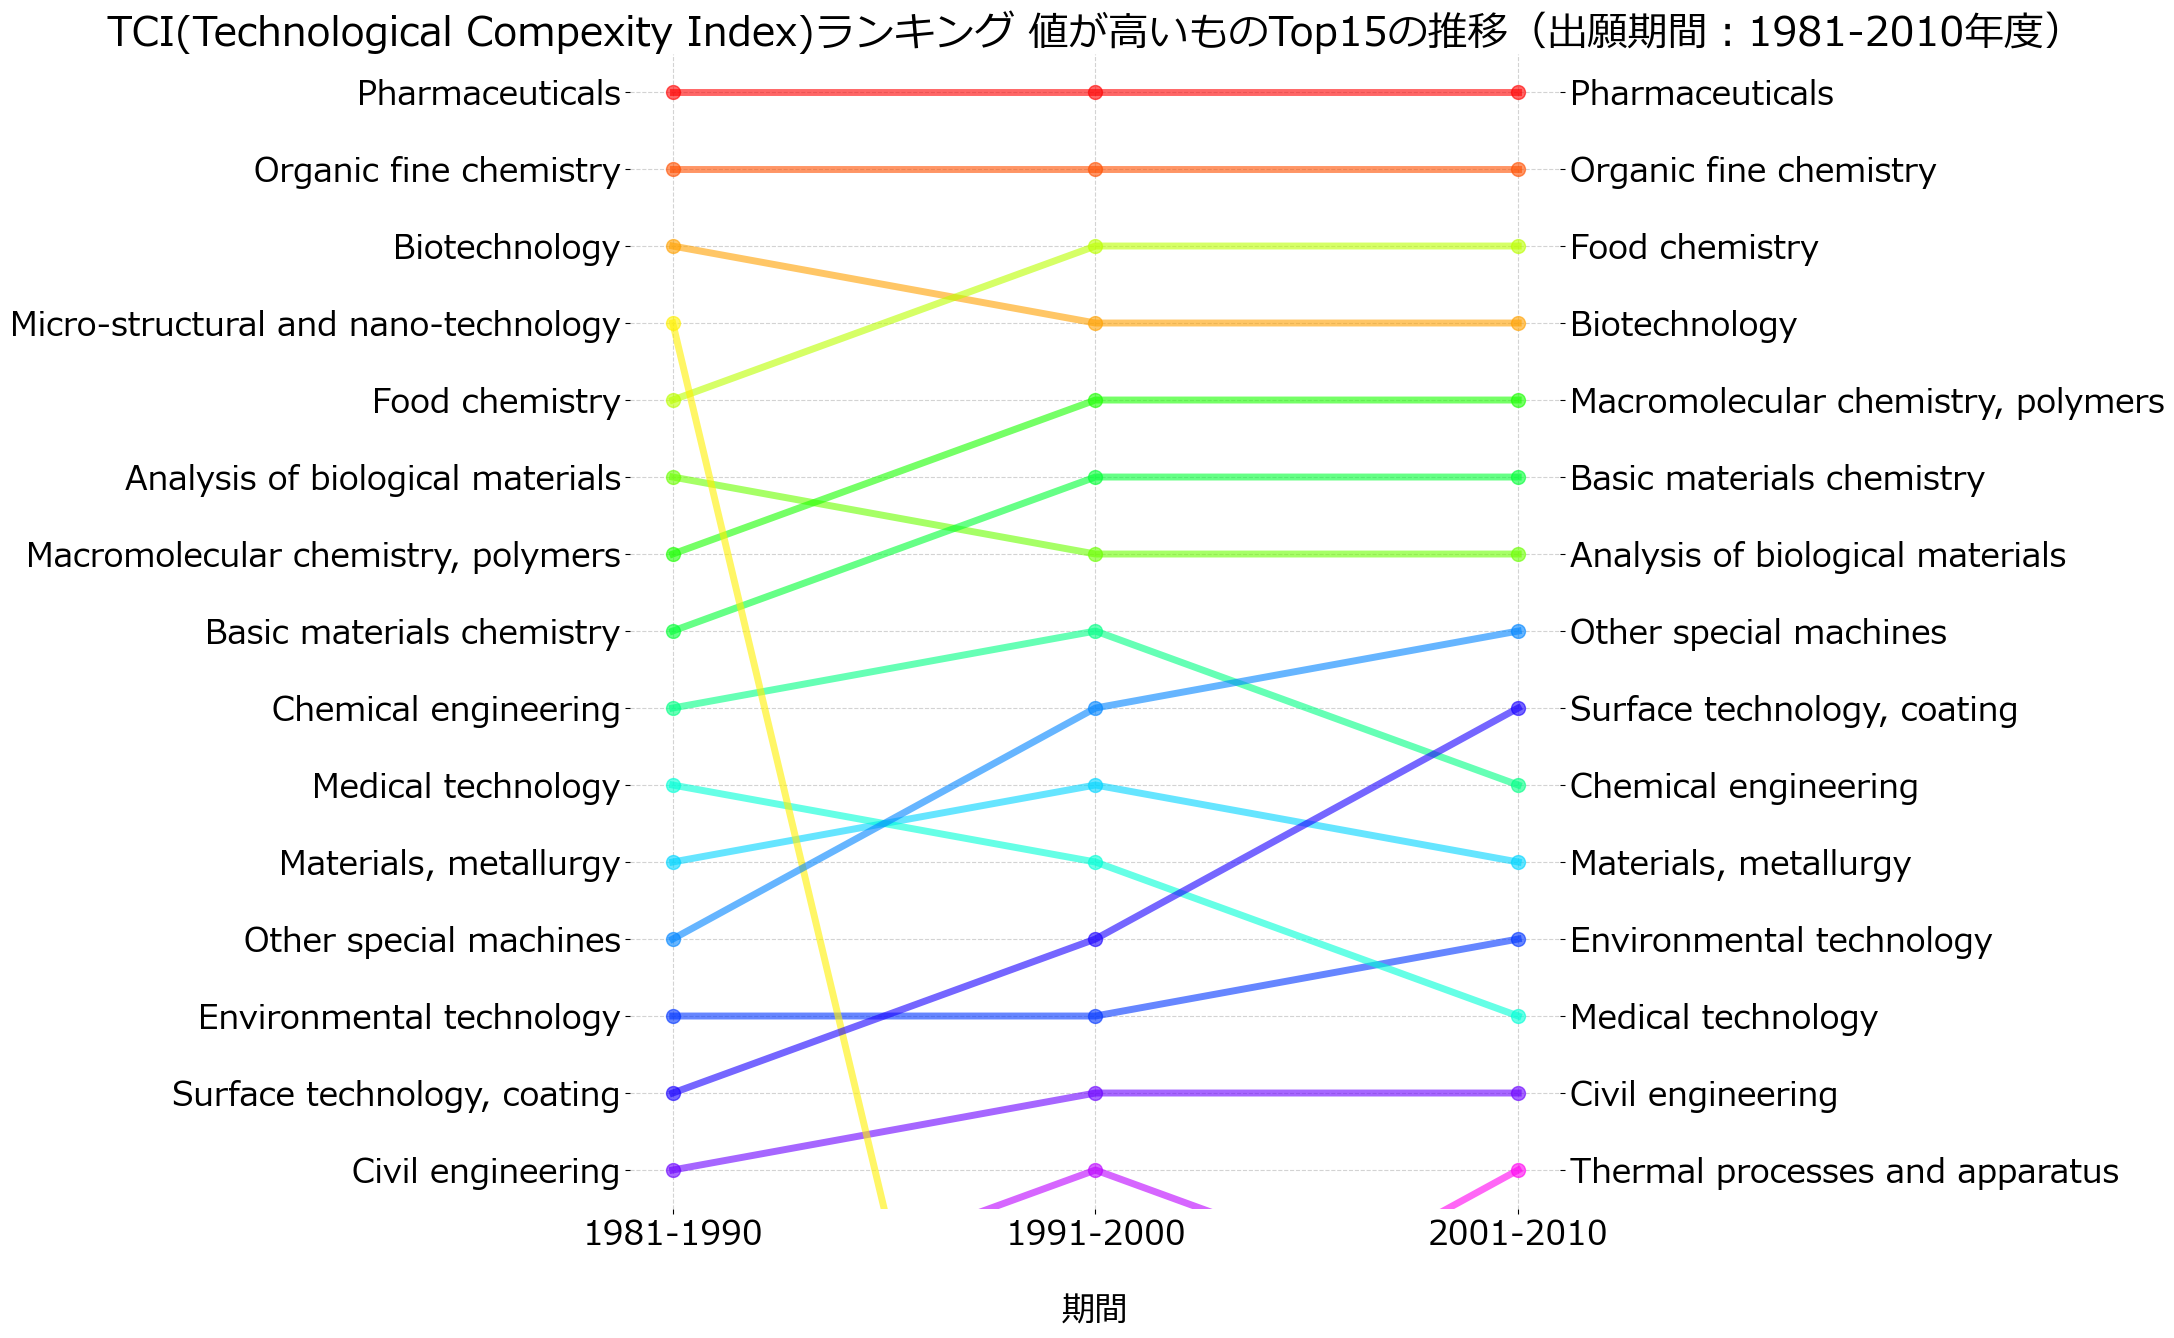

In [13]:
df_dict = {}
combi_dict = {# 1: ['right_person_name', 'Ubiquity', f'特許権者次数(=Ubiquity，k_h0)ランキング 値が小さいものTop15の推移（出願期間：{year_start}-{year_end}年度）', True], 
              # 1: ['right_person_name', '', f'特許権者次数(=Ubiquity，k_h0)ランキング 値が小さいものTop15の推移（出願期間：{year_start}-{year_end}年度）', True], 
              # 2: ['right_person_name', 'Ubiquity', f'特許権者次数(=Ubiquity，k_h0)ランキング 値が大きいものTop15の推移（出願期間：{year_start}-{year_end}年度）', False], 
              # 3: ['right_person_name', 'eci', f'KCIランキング 値が小さいものTop15の推移（出願期間：{year_start}-{year_end}年度）', True], 
              # 3: ['right_person_name', 'ipc_class_num', f'IPC数ランキング 値が大きいものTop15の推移（出願期間：{year_start}-{year_end}年度）', False], 
              # 4: ['right_person_name', 'kci', f'KCIランキング 値が大きいものTop15の推移（出願期間：{year_start}-{year_end}年度）', False], 
              5: [classification, 'ubiquity', f'IPC次数(=ubiquity, k_i0)ランキング 低次数Top15の推移（出願期間：{year_start}-{year_end}年度）', True], 
              # 6: ['ipc_class', 'ubiquity', f'IPC次数(=ubiquity, k_i0)ランキング 高次数Top15の推移（出願期間：{year_start}-{year_end}年度）', False], 
              # 7: ['ipc_class', 'pci', f'TCI(Technological Compexity Index)ランキング 値が低いものTop15の推移（出願期間：{year_start}-{year_end}年度）', True], 
              8: [classification, 'tci', f'TCI(Technological Compexity Index)ランキング 値が高いものTop15の推移（出願期間：{year_start}-{year_end}年度）', False]
              }


for i, combi in combi_dict.items():
    div_df = df[[f'{ar}_{year_style}_period']+combi[:1+1]].sort_values(by=[f'{ar}_{year_style}_period', combi[1]], ascending=[True, False]).copy()
    div_df = div_df.drop_duplicates(keep='first')
    div_df_dict = {}
    for year in range(year_start, year_end+1, year_range):
        period = f'{year}-{year+year_range-1}'
        div_df_dict[period] = div_df[div_df[f'{ar}_{year_style}_period']==period].copy()
        # display(div_df_dict[f'{year}-{year+year_range-1}'].head(15))
    if i==4:
        df['kci_rank'] = df.groupby(f'{ar}_{year_style}_period')[['kci']].rank(ascending=False, method='first').reset_index(drop=False)['kci']
        # display(c_df[c_df['right_person_name'].str.contains('三菱重工業')])
    if i > 4: fs = (12, 15)
    else: fs = (10, 12)
    # display(div_df)
    sample = vr.rank_doubleaxis(div_df_dict, 
                version='kci', 
                    rank_num=15,
                    member_col=combi[0], 
                    num_col=combi[1],
                    prop_dict={
                        'figsize': fs,
                        'xlabel': '期間',
                        'ylabel': '',
                        'title': combi[2],
                        'fontsize': 24, 
                        'year_range': year_range, 
                        'ascending': combi[3], 
                        # 'color': color_dict
                        'color': 'default'
                    })
    plt.savefig(f'{output_dir}/figures/{combi[1]}_{ar}_{year_style}_{top_p_or_num[0]}_{top_p_or_num[1]}.png')
    plt.show()
